In [1]:
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn


from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer




In [2]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

### Data manipulation and cleanup

In [3]:
df = pd.read_csv('survey data.csv')

df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213 entries, 0 to 212
Data columns (total 166 columns):
 #    Column                              Dtype  
---   ------                              -----  
 0    variant                             object 
 1    group                               object 
 2    age                                 int64  
 3    gender_1F_2M_3O                     int64  
 4    education_level                     int64  
 5    education_level_otherSpecification  object 
 6    income_level                        int64  
 7    Country_birth                       object 
 8    English_proficiency                 int64  
 9    religion                            int64  
 10   religion_other_spec                 object 
 11   meditation_freq                     int64  
 12   meditation_howlong                  int64  
 13   medit_type_silent                   int64  
 14   medit_type_voice                    int64  
 15   medit_type_breath                   in

In [4]:
# Saving a csv file for parallel analysis with GPT-4
df[['group', 'Open_report typo-corrected']].to_csv('open_report_for_gpt4.csv', index=False)


In [5]:
# Only keeping the columns that we need

columns_to_keep = ['group', 'age', 'gender_1F_2M_3O', 'income_level', 'education_level', 'Open_report typo-corrected']

df = df[columns_to_keep] 

df

,group,age,gender_1F_2M_3O,income_level,education_level,Open_report typo-corrected
0,meditation,64,2,2,4,There is a fundamental concept in Buddhism cal...
1,meditation,31,2,4,7,I developed all positive feelings. All thought...
2,meditation,45,1,2,7,I had recently lost my father unexpectedly. A ...
3,meditation,33,2,3,6,There was an objective experience of the self ...
4,meditation,56,2,4,6,Deep abiding peace with understanding of the i...
...,...,...,...,...,...,...
208,psychedelics,31,2,2,7,"It's impossible to write down what happened, a..."
209,psychedelics,31,2,3,6,You are okay I took approximately half of what...
210,psychedelics,56,1,5,6,There was an intention setting and intake appt...
211,psychedelics,40,1,4,7,My memory is quite vague as it was almost 5 ye...


In [6]:
# # Replacing the abbreviation gf with the actual word girlfriend (this came up while running some preliminary analyses)
df['Open_report typo-corrected'] = df['Open_report typo-corrected'].str.replace('gf ', 'girlfriend ')
df['Open_report typo-corrected'] = df['Open_report typo-corrected'].str.replace('gf)', 'girlfriend)')


In [7]:
# Dropping rows where open report is empty
df = df.dropna(subset=['Open_report typo-corrected'])

In [8]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 203 entries, 0 to 212
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   group                       203 non-null    object
 1   age                         203 non-null    int64 
 2   gender_1F_2M_3O             203 non-null    int64 
 3   income_level                203 non-null    int64 
 4   education_level             203 non-null    int64 
 5   Open_report typo-corrected  203 non-null    object
dtypes: int64(4), object(2)
memory usage: 11.1+ KB


In [9]:
df.loc[:, 'group'] = df['group'].astype('category')
df.loc[:, 'Open_report typo-corrected'] = df['Open_report typo-corrected'].astype('string')

In [10]:
# Creating separate dataframes for psychedelics and meditation groups

psyke = df[df['group']=='psychedelics']

medi = df[df['group']=='meditation']

psyke_count = len(psyke)
medi_count = len(medi)

print(f"Number of answers in 'psychedelics' group: {psyke_count}")
print(f"Number of answers in 'meditation' group: {medi_count}")

Number of answers in 'psychedelics' group: 138
Number of answers in 'meditation' group: 65


### Demographic data about the participants

In [11]:
# Replace gender values according to the instructions
df['gender_1F_2M_3O'].replace({1: 'female', 2: 'male', 3: 'other'}, inplace=True)

gender_distribution = df['gender_1F_2M_3O'].value_counts()
gender_distribution_percentage = round(df['gender_1F_2M_3O'].value_counts(normalize=True) * 100, 2)
print("Gender distribution:\n", gender_distribution)
print("\nGender distribution (in percentage):\n", gender_distribution_percentage)

mean_age = round(df['age'].mean(), 2)
std_age = round(df['age'].std(), 2)
print(f"Mean age: {mean_age} (std: {std_age})")

mean_income = round(df['income_level'].mean(), 2)
std_income = round(df['income_level'].std(), 2)
print(f"Mean income level: {mean_income} (std: {std_income})")


mean_education_level = round(df['education_level'].mean(), 2)
std_education_level = round(df['education_level'].std(), 2)
print(f"Mean education level: {mean_education_level} (std: {std_education_level})")



Gender distribution:
 gender_1F_2M_3O
male      120
female     79
other       4
Name: count, dtype: int64

Gender distribution (in percentage):
 gender_1F_2M_3O
male      59.11
female    38.92
other      1.97
Name: proportion, dtype: float64
Mean age: 43.13 (std: 14.48)
Mean income level: 3.16 (std: 1.14)
Mean education level: 59.92 (std: 225.34)


/var/folders/1_/ff72pvzx3tqc2qtzyq7wlzxm0000gn/T/ipykernel_96228/2307297222.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender_1F_2M_3O'].replace({1: 'female', 2: 'male', 3: 'other'}, inplace=True)


Education level distribution:
 education_level
7      70
6      64
8      25
3      17
999    11
4       9
2       6
1       1
Name: count, dtype: int64

Education level distribution (in percentage):
 education_level
7      34.48
6      31.53
8      12.32
3       8.37
999     5.42
4       4.43
2       2.96
1       0.49
Name: proportion, dtype: float64


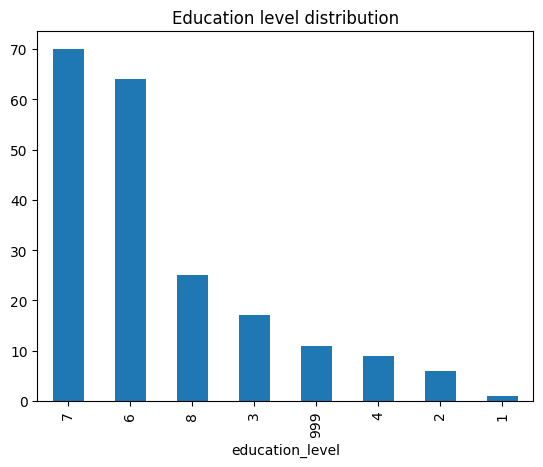

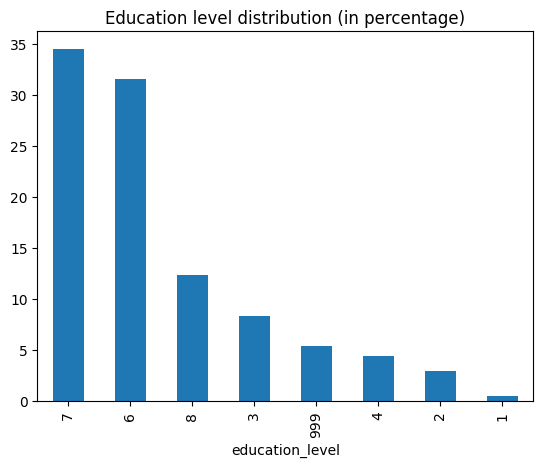

In [12]:
education_level_distribution = df['education_level'].value_counts()
education_level_distribution_percentage = round(df['education_level'].value_counts(normalize=True) * 100, 2)
print("Education level distribution:\n", education_level_distribution)
print("\nEducation level distribution (in percentage):\n", education_level_distribution_percentage)

education_level_distribution.plot(kind='bar', title='Education level distribution')
plt.show()

education_level_distribution_percentage.plot(kind='bar', title='Education level distribution (in percentage)')
plt.show()


### Checking word distributions

In [13]:
total_words = df['Open_report typo-corrected'].str.split().apply(lambda x : len(x)).sum()
print(f"Total number of words in 'Open_report typo-corrected': {total_words}")


Total number of words in 'Open_report typo-corrected': 72996


<Axes: >

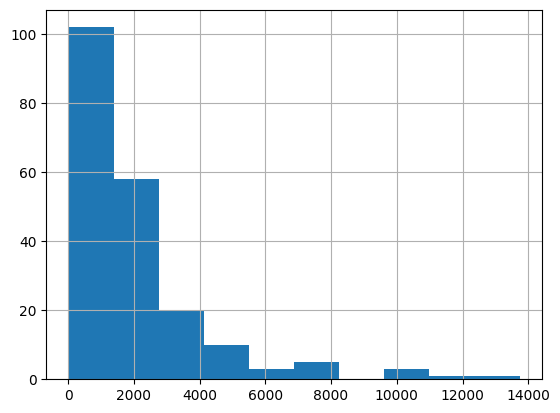

In [14]:
# Histogram of the answer lengths (in tokens)

df['Open_report typo-corrected'].str.len().hist()

<Axes: >

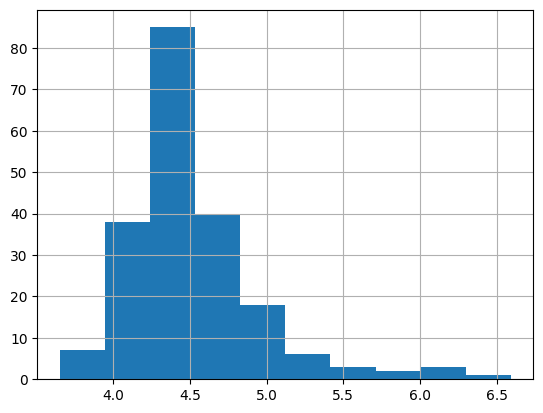

In [15]:
# Histogram of word lengths

df['Open_report typo-corrected'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

Text(0, 0.5, 'Count of Answers')

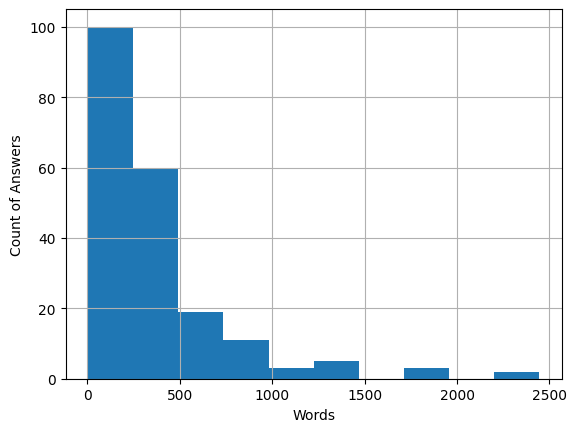

In [16]:
# Histogram of answer lengths (in words)

ax = df['Open_report typo-corrected'].str.split().apply(lambda x : len(x)).hist()
ax.set_xlabel("Words")
ax.set_ylabel("Count of Answers")


In [17]:
# Average length of the documents for all groups
avg_answer_length = round(df['Open_report typo-corrected'].str.split().apply(lambda x : len(x)).mean(), 2)
std_answer_length = round(df['Open_report typo-corrected'].str.split().apply(lambda x : len(x)).std(), 2)
print(f"Average length of answers in words for all groups: {avg_answer_length} (std: {std_answer_length})")

# Average length of the documents for 'psychedelics' group
avg_answer_length_psyke = round(psyke['Open_report typo-corrected'].str.split().apply(lambda x : len(x)).mean(), 2)
std_answer_length_psyke = round(psyke['Open_report typo-corrected'].str.split().apply(lambda x : len(x)).std(), 2)
print(f"Average length of answers in words for 'psychedelics' group: {avg_answer_length_psyke} (std: {std_answer_length_psyke})")

# Average length of the documents for 'meditation' group
avg_answer_length_medi = round(medi['Open_report typo-corrected'].str.split().apply(lambda x : len(x)).mean(), 2)
std_answer_length_medi = round(medi['Open_report typo-corrected'].str.split().apply(lambda x : len(x)).std(), 2)
print(f"Average length of answers in words for 'meditation' group: {avg_answer_length_medi} (std: {std_answer_length_medi})")


Average length of answers in words for all groups: 359.59 (std: 401.19)
Average length of answers in words for 'psychedelics' group: 400.41 (std: 443.66)
Average length of answers in words for 'meditation' group: 272.92 (std: 274.63)


<BarContainer object of 10 artists>

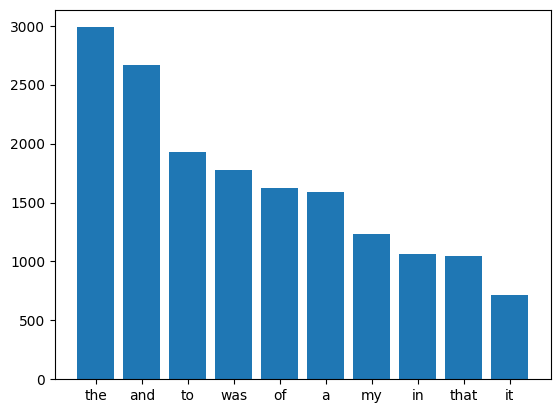

In [18]:
# Visualising the most common stopwords in the dataset
stop_words = set(stopwords.words('english'))

corpus = []
words = df['Open_report typo-corrected'].str.split()
words = words.values.tolist()
corpus = [word for i in words for word in i]

from collections import defaultdict

dic=defaultdict(int)
for word in corpus:
    if word in stop_words:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y)

# Word frequency comparisons between the groups

In [19]:
from collections import Counter
import spacy


In [20]:
nlp = spacy.load("en_core_web_sm")

psyke_all_text = psyke['Open_report typo-corrected'].str.cat(sep=' ')

psyke_doc = nlp(psyke_all_text, disable=['ner'])

In [21]:
medi_all_text = medi['Open_report typo-corrected'].str.cat(sep=' ')

medi_doc = nlp(medi_all_text, disable=['ner'])


In [33]:
psyke_words = [token.lemma_ for token in psyke_doc if not token.is_stop and not token.is_punct and token.lemma_ != ' '] 
psyke_word_freq = Counter(psyke_words) 
psyke_word_freq.most_common(20)

[('feel', 569),
 ('experience', 388),
 ('like', 342),
 ('time', 241),
 ('start', 222),
 ('go', 175),
 ('life', 159),
 ('friend', 158),
 ('know', 144),
 ('think', 140),
 ('come', 134),
 ('trip', 134),
 ('take', 133),
 ('see', 129),
 ('thing', 114),
 ('get', 112),
 ('remember', 111),
 ('feeling', 107),
 ('body', 101),
 ('look', 101)]

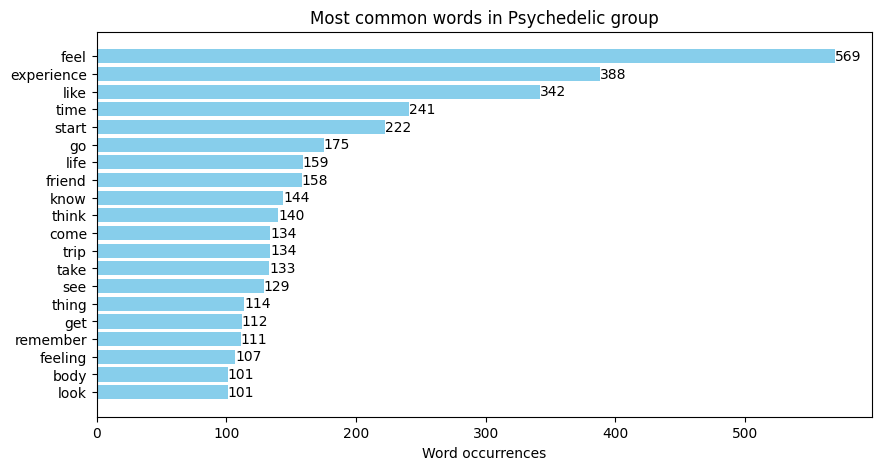

In [23]:
psyke_common_words = psyke_word_freq.most_common(20)
words, counts = zip(*psyke_common_words)

plt.figure(figsize=(10, 5))
bars = plt.barh(words, counts, color='skyblue')
plt.xlabel('Word occurrences')
plt.title('Most common words in Psychedelic group')
plt.gca().invert_yaxis()

# Add counts next to the bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width()}', 
             va='center', ha='left')

plt.show()


In [24]:
medi_words = [token.lemma_ for token in medi_doc if not token.is_stop and not token.is_punct and token.lemma_ != ' '] 
medi_word_freq = Counter(medi_words) 
medi_word_freq.most_common(20)

[('experience', 190),
 ('feel', 154),
 ('like', 91),
 ('meditation', 89),
 ('time', 80),
 ('body', 77),
 ('day', 69),
 ('practice', 57),
 ('retreat', 56),
 ('mind', 52),
 ('life', 50),
 ('know', 42),
 ('come', 38),
 ('year', 37),
 ('happen', 36),
 ('love', 36),
 ('start', 34),
 ('sense', 34),
 ('go', 34),
 ('sit', 32)]

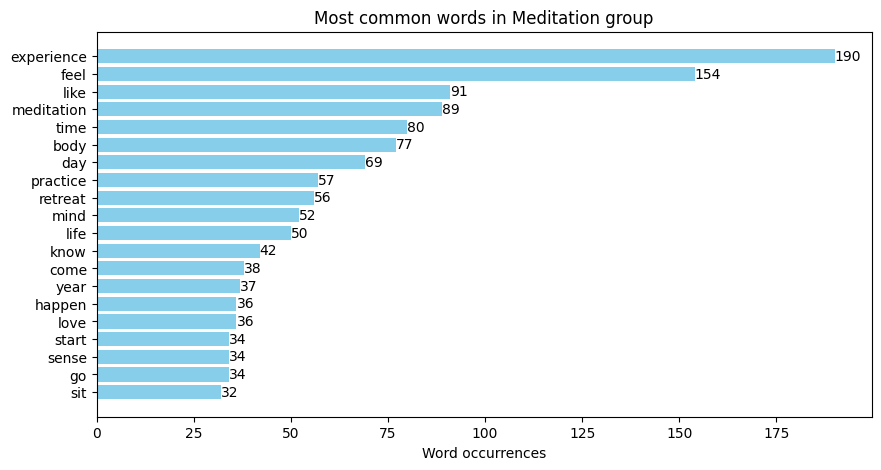

In [26]:
medi_common_words = medi_word_freq.most_common(20)
words, counts = zip(*medi_common_words)

plt.figure(figsize=(10, 5))
bars = plt.barh(words, counts, color='skyblue')
plt.xlabel('Word occurrences')
plt.title('Most common words in Meditation group')
plt.gca().invert_yaxis()

# Add counts next to the bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width()}', 
             va='center', ha='left')

plt.show()



### Most common ngrams

In [27]:
# Defining the functions for finding most common ngrams without stopwords

from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngram_without_stop(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    words_freq = [(word, count) for word, count in words_freq if all(w not in stop_words for w in word.split())]
    return words_freq[:10]


Text(0.5, 1.0, 'Psychedelic group most common bigrams')

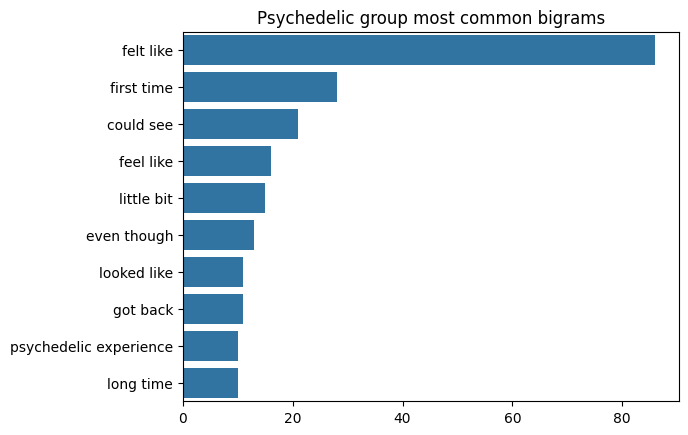

In [28]:
# Top bigrams without stopwords psychedelic group – no lemmatising yet in order to preserve the meaning of the words
top_n_bigrams_psyke=get_top_ngram_without_stop(psyke['Open_report typo-corrected'],2)[:10] 

x,y=map(list,zip(*top_n_bigrams_psyke)) 

sns.barplot(x=y,y=x).set_title("Psychedelic group most common bigrams")


Text(0.5, 1.0, 'Meditation group most common bigrams')

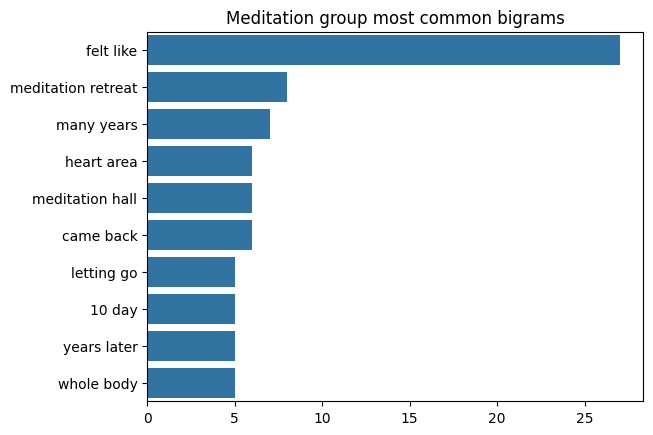

In [29]:
# Top bigrams without stopwords meditation group – also without lemmatising
top_n_bigrams_medi=get_top_ngram_without_stop(medi['Open_report typo-corrected'],2)[:10] 

x,y=map(list,zip(*top_n_bigrams_medi)) 

sns.barplot(x=y,y=x).set_title("Meditation group most common bigrams")

# Using the spacy approach 

#### https://robertorocha.info/using-nlp-to-analyze-open-ended-responses-in-surveys/

In [46]:
all_text = df['Open_report typo-corrected'].str.cat(sep=' ')

doc = nlp(all_text, disable=['ner'])

In [47]:
from spacy.matcher import Matcher 

matcher = Matcher(nlp.vocab) 
pattern = [{'POS':'ADJ'}, {'POS':'NOUN'}] 
matcher.add('ADJ_PHRASE', [pattern]) 

matches = matcher(doc, as_spans=True) 
phrases = [] 
for span in matches:
    phrases.append(span.text.lower())
    phrase_freq = Counter(phrases)

phrase_freq.most_common(30)

[('first time', 32),
 ('same time', 16),
 ('little bit', 16),
 ('other people', 15),
 ('long time', 13),
 ('many years', 12),
 ('psychedelic experience', 10),
 ('whole body', 9),
 ('few hours', 9),
 ('next day', 8),
 ('few times', 8),
 ('present moment', 8),
 ('psychedelic experiences', 8),
 ('many times', 7),
 ('everyday life', 6),
 ('whole life', 6),
 ('whole universe', 6),
 ('several hours', 6),
 ('few days', 6),
 ('hard time', 6),
 ('whole experience', 5),
 ('first thing', 5),
 ('nervous system', 5),
 ('same thing', 5),
 ('ego death', 5),
 ('magic mushrooms', 5),
 ('total bliss', 5),
 ('mental health', 4),
 ('important part', 4),
 ('unconditional love', 4)]

In [52]:
# Same only for the 'psyke' dataframe
psyke_all_text = psyke['Open_report typo-corrected'].str.cat(sep=' ')
psyke_doc = nlp(psyke_all_text, disable=['ner'])

In [53]:
matcher = Matcher(nlp.vocab) 
pattern = [{'POS':'ADJ'}, {'POS':'NOUN'}] 
matcher.add('ADJ_PHRASE', [pattern]) 

matches = matcher(psyke_doc, as_spans=True) 
phrases = [] 
for span in matches:
    phrases.append(span.text.lower())
psyke_phrase_freq = Counter(phrases)


psyke_phrase_freq.most_common(20)

[('first time', 28),
 ('little bit', 14),
 ('psychedelic experience', 10),
 ('long time', 10),
 ('other people', 10),
 ('same time', 9),
 ('few hours', 9),
 ('psychedelic experiences', 8),
 ('few times', 7),
 ('present moment', 6),
 ('hard time', 6),
 ('next day', 6),
 ('same thing', 5),
 ('ego death', 5),
 ('few days', 5),
 ('many years', 5),
 ('several hours', 5),
 ('magic mushrooms', 5),
 ('total bliss', 5),
 ('many times', 4)]

In [54]:
# And for the medi dataframe
medi_all_text = medi['Open_report typo-corrected'].str.cat(sep=' ')
medi_doc = nlp(medi_all_text, disable=['ner'])

In [56]:
matcher = Matcher(nlp.vocab) 
pattern = [{'POS':'ADJ'}, {'POS':'NOUN'}] 
matcher.add('ADJ_PHRASE', [pattern]) 

matches = matcher(medi_doc, as_spans=True) 
phrases = [] 
for span in matches:
    phrases.append(span.text.lower())
medi_phrase_freq = Counter(phrases)

medi_phrase_freq.most_common(20)

[('many years', 7),
 ('same time', 7),
 ('other people', 5),
 ('whole body', 5),
 ('first time', 4),
 ('other thoughts', 3),
 ('long time', 3),
 ('many times', 3),
 ('free flow', 3),
 ('deep meditation', 3),
 ('ordinary life', 3),
 ('emotional spectrum', 3),
 ('next day', 2),
 ('meaningful experiences', 2),
 ('discrete moments', 2),
 ('natural state', 2),
 ('many others', 2),
 ('important part', 2),
 ('unconditional love', 2),
 ('negative feelings', 2)]

In [58]:
# Checking which words occur near the word "experience"

from spacy.matcher import PhraseMatcher

experience_colloc = []
matcher = PhraseMatcher(nlp.vocab, attr = 'LOWER') 
# The attr above ensures all instances are converted to lower-case so the search is case-insensitive

pattern = [nlp.make_doc('experience')]
matcher.add('experience', pattern) 
matches = matcher(doc)

for match_id, start, end in matches:
    span = doc[start-10 : end+10]   
    experience_colloc.extend([token.lemma_.lower() for token in span if not token.is_stop and not token.is_punct]) 

Counter(experience_colloc).most_common(20)

[('experience', 478),
 ('feel', 62),
 (' ', 33),
 ('time', 32),
 ('like', 31),
 ('life', 29),
 ('psychedelic', 25),
 ('think', 21),
 ('happen', 21),
 ('way', 21),
 ('day', 20),
 ('change', 19),
 ('take', 19),
 ('feeling', 18),
 ('start', 17),
 ('go', 17),
 ('hour', 17),
 ('body', 16),
 ('trip', 15),
 ('year', 14)]

In [60]:
psyke_experience_colloc = []
matcher = PhraseMatcher(nlp.vocab, attr = 'LOWER') 
# The attr above ensures all instances are converted to lower-case so the search is case-insensitive

pattern = [nlp.make_doc('experience')]
matcher.add('experience', pattern) 
matches = matcher(doc)

for match_id, start, end in matches:
    span = doc[start-10 : end+10]   
    psyke_experience_colloc.extend([token.lemma_.lower() for token in span if not token.is_stop and not token.is_punct]) 

Counter(psyke_experience_colloc).most_common(20)


[('experience', 478),
 ('feel', 62),
 (' ', 33),
 ('time', 32),
 ('like', 31),
 ('life', 29),
 ('psychedelic', 25),
 ('think', 21),
 ('happen', 21),
 ('way', 21),
 ('day', 20),
 ('change', 19),
 ('take', 19),
 ('feeling', 18),
 ('start', 17),
 ('go', 17),
 ('hour', 17),
 ('body', 16),
 ('trip', 15),
 ('year', 14)]

In [59]:
medi_experience_colloc = []
matcher = PhraseMatcher(nlp.vocab, attr = 'LOWER') 
# The attr above ensures all instances are converted to lower-case so the search is case-insensitive

pattern = [nlp.make_doc('experience')]
matcher.add('experience', pattern) 
matches = matcher(medi_doc)

for match_id, start, end in matches:
    span = medi_doc[start-10 : end+10]   
    medi_experience_colloc.extend([token.lemma_.lower() for token in span if not token.is_stop and not token.is_punct]) 

Counter(medi_experience_colloc).most_common(20)


[('experience', 158),
 ('feel', 17),
 ('like', 12),
 ('body', 11),
 ('time', 11),
 ('happen', 11),
 ('retreat', 10),
 ('meditation', 10),
 ('year', 9),
 ('change', 7),
 ('think', 7),
 ('day', 7),
 ('let', 6),
 ('life', 6),
 ('know', 6),
 ('moment', 5),
 ('come', 5),
 ('self', 5),
 ('state', 5),
 ('thing', 5)]

### Creating pre-processed dataframes for both groups
Previously the stopwords were removed and words lemmatised while calculating the frequencies, but I didn't touch the actual dataframes. Now, we need preprocessed dataframes for LDA and Sentiment analysis.  

In [62]:
lemmatizer = WordNetLemmatizer()
nltk.download('averaged_perceptron_tagger')

# Creating the pre-processing functions
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# Defining a mapping of words to their base forms
manual_mapping = {
    'felt': 'feel',
    'talked': 'talk',
    'thought': 'think',
}

def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [manual_mapping.get(token, token) for token in tokens] 
    tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens if token.isalpha() and token not in stop_words]
    return ' '.join(tokens)



[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/konsta/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [63]:
# Pre-processing psyke and medi datasets

psyke_pre_processed_answers = psyke['Open_report typo-corrected'].apply(preprocess_text)
medi_pre_processed_answers = medi['Open_report typo-corrected'].apply(preprocess_text)



## TF-IDF analysis

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create the tf-idf vectorizers
tfidf_vectorizer_psyke = TfidfVectorizer()
tfidf_vectorizer_medi = TfidfVectorizer()

# Apply the vectorizers to the preprocessed answers
X_psyke = tfidf_vectorizer_psyke.fit_transform(psyke_pre_processed_answers)
X_medi = tfidf_vectorizer_medi.fit_transform(medi_pre_processed_answers)



Psychedelic group top words:


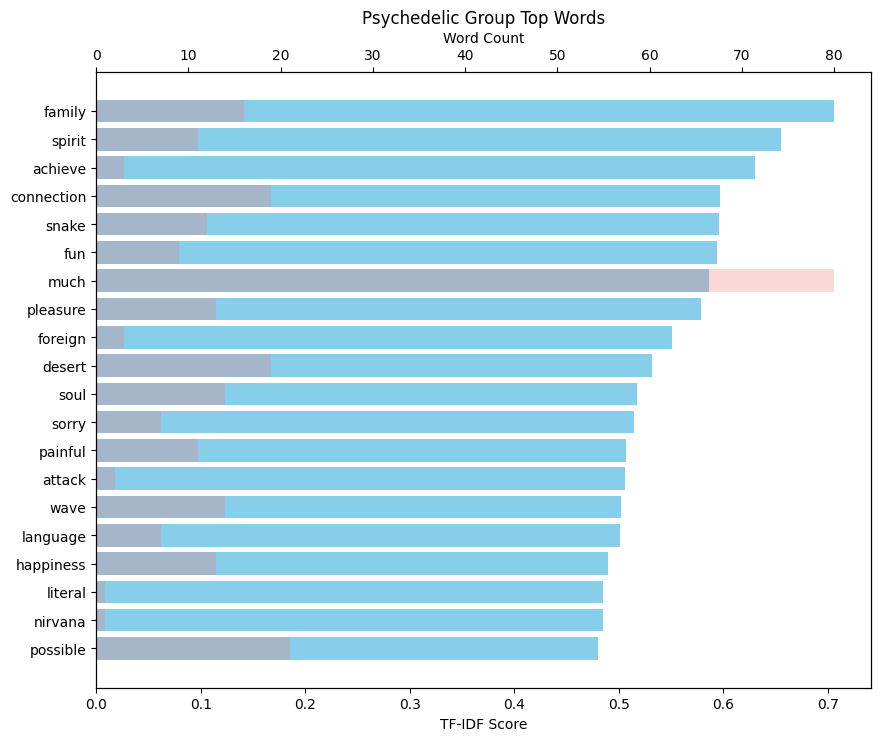

Meditation group top words:


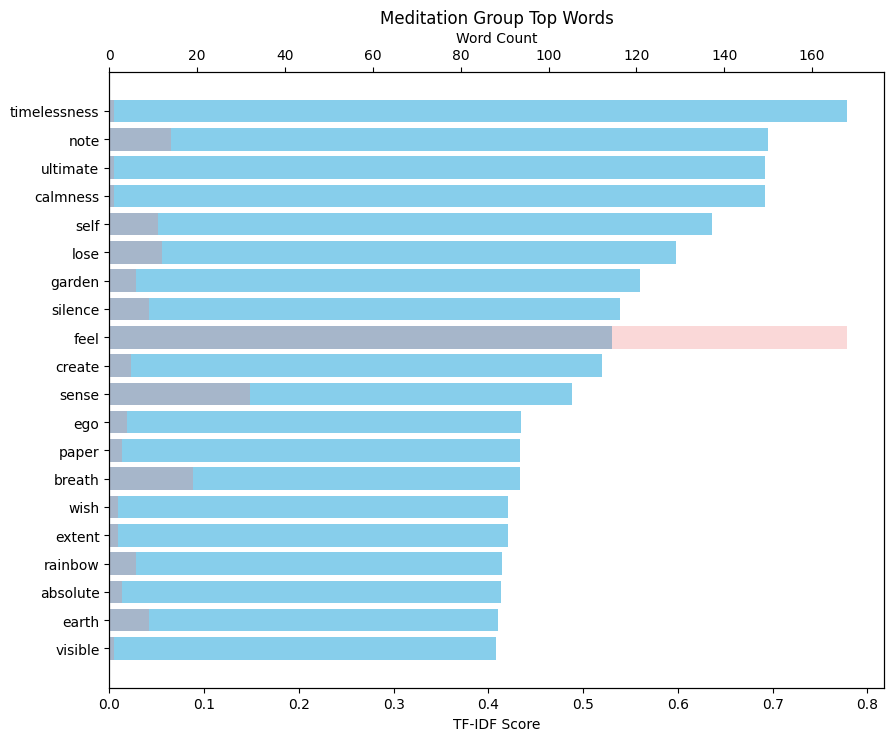

In [65]:
# Create the count vectorizers
count_vectorizer_psyke = CountVectorizer()
count_vectorizer_medi = CountVectorizer()

# Apply the vectorizers to the preprocessed answers
X_psyke_count = count_vectorizer_psyke.fit_transform(psyke_pre_processed_answers)
X_medi_count = count_vectorizer_medi.fit_transform(medi_pre_processed_answers)

def plot_top_tfidf_words(vectorizer, tfidf_result, count_vectorizer, count_result, top_n, title):
    feature_names = vectorizer.get_feature_names_out()
    sorted_nzs = np.argsort(tfidf_result.data)[:-(top_n+1):-1]
    top_words = feature_names[tfidf_result.indices[sorted_nzs]]
    top_scores = tfidf_result.data[sorted_nzs]
    
    # Get word counts
    word_counts = count_result.sum(axis=0).A1
    count_dict = dict(zip(count_vectorizer.get_feature_names_out(), word_counts))
    top_counts = [count_dict[word] for word in top_words]
    
    fig, ax1 = plt.subplots(figsize=(10, 8))

    # Plot TF-IDF scores
    ax1.barh(top_words, top_scores, color='skyblue')
    ax1.set_xlabel('TF-IDF Score')
    ax1.set_title(title)

    # Plot word counts on the same graph but with a different x-axis
    ax2 = ax1.twiny()
    ax2.barh(top_words, top_counts, color='lightcoral', alpha=0.3)
    ax2.set_xlabel('Word Count')

    # Invert y-axis
    plt.gca().invert_yaxis()
    plt.show()

# Psychedelic group
print("Psychedelic group top words:")
plot_top_tfidf_words(tfidf_vectorizer_psyke, X_psyke, count_vectorizer_psyke, X_psyke_count, 20, 'Psychedelic Group Top Words')

# Meditation group
print("Meditation group top words:")
plot_top_tfidf_words(tfidf_vectorizer_medi, X_medi, count_vectorizer_medi, X_medi_count, 20, 'Meditation Group Top Words')

# Topic analysis with LDA

### Testing the LDA model with different number of topics (k) and checking words inside the topic models 

In [67]:
# Psychedelic data

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Define the number of topics for each model
num_topics_list = [3, 5, 10, 15, 20, 25, 30]

# Vectorizing the preprocessed text and creating document-term matrices
vectorizer_psyke = CountVectorizer()
psyke_dtm = vectorizer_psyke.fit_transform(psyke_pre_processed_answers)

# Function to print top 10 words for each topic
def print_top_words(model, vectorizer, n_top_words=10):
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic #{topic_idx + 1}: "
        message += ", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

# Train LDA models and print top words
for num_topics in num_topics_list:
    print(f"\nModel with {num_topics} topics:")
    lda_model_medi = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda_model_medi.fit(psyke_dtm)
    print_top_words(lda_model_medi, vectorizer_psyke)


Model with 3 topics:
Topic #1: vision, like, city, love, wife, consciousness, look, go, move, call
Topic #2: feel, like, experience, time, go, start, could, one, get, take
Topic #3: feel, experience, like, go, time, start, one, get, think, take

Model with 5 topics:
Topic #1: like, remember, look, vision, feel, wife, call, move, mushroom, go
Topic #2: feel, like, go, start, could, get, friend, time, experience, take
Topic #3: feel, experience, like, go, start, time, one, get, think, friend
Topic #4: desert, note, love, make, experience, campsite, go, able, also, realise
Topic #5: feel, experience, like, time, one, life, start, take, could, go

Model with 10 topics:
Topic #1: like, feel, go, remember, look, vision, wife, love, experience, call
Topic #2: feel, go, start, experience, like, get, make, love, friend, could
Topic #3: feel, like, experience, go, start, time, get, remember, think, take
Topic #4: explain, happen, also, able, trauma, year, issue, spirit, suffer, train
Topic #5: 

In [68]:
# Meditation data

# Vectorize the preprocessed text
vectorizer_medi = CountVectorizer()
medi_dtm = vectorizer_medi.fit_transform(medi_pre_processed_answers)

# Train LDA models and print top words
for num_topics in num_topics_list:
    print(f"\nModel with {num_topics} topics:")
    lda_model_medi = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda_model_medi.fit(medi_dtm)
    print_top_words(lda_model_medi, vectorizer_medi)


Model with 3 topics:
Topic #1: experience, meditation, note, think, day, feel, retreat, body, life, like
Topic #2: feel, experience, body, meditation, like, day, retreat, practice, time, go
Topic #3: experience, time, like, feel, mind, life, meditation, state, one, could

Model with 5 topics:
Topic #1: experience, time, day, intense, see, realize, breath, hearing, really, use
Topic #2: feel, experience, like, day, body, meditate, one, time, word, go
Topic #3: experience, time, mind, could, like, feel, life, state, nyams, yet
Topic #4: feel, experience, meditation, body, like, practice, retreat, life, day, could
Topic #5: time, experience, retreat, go, heart, feel, practice, happen, many, back

Model with 10 topics:
Topic #1: time, experience, intense, realize, day, use, breath, hearing, really, act
Topic #2: feel, experience, one, garden, use, state, go, time, calm, day
Topic #3: experience, time, different, level, mind, state, colour, something, rainbow, light
Topic #4: experience, f

### Final topic models for psychedelic and meditation groups
Defined by using the model from Wheeler et al. (2021): https://link.springer.com/chapter/10.1007/978-3-030-74772-5_24. However, with meditation group the article's recommendations are not followed (it suggests using only 2 topics for meditation), because I wanted to have same amount of topics for the both model, which also would make sense for human readers. Therefore, the k parameter is set to 5 with both datasets.

In [69]:
lda_model_psyke = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model_psyke.fit(psyke_dtm)
print("Psychedelics:")
print_top_words(lda_model_psyke, vectorizer_psyke)

lda_model_medi = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model_medi.fit(medi_dtm)
print("Meditation:")
print_top_words(lda_model_medi, vectorizer_medi)


Psychedelics:
Topic #1: like, remember, look, vision, feel, wife, call, move, mushroom, go
Topic #2: feel, like, go, start, could, get, friend, time, experience, take
Topic #3: feel, experience, like, go, start, time, one, get, think, friend
Topic #4: desert, note, love, make, experience, campsite, go, able, also, realise
Topic #5: feel, experience, like, time, one, life, start, take, could, go
Meditation:
Topic #1: experience, time, day, intense, see, realize, breath, hearing, really, use
Topic #2: feel, experience, like, day, body, meditate, one, time, word, go
Topic #3: experience, time, mind, could, like, feel, life, state, nyams, yet
Topic #4: feel, experience, meditation, body, like, practice, retreat, life, day, could
Topic #5: time, experience, retreat, go, heart, feel, practice, happen, many, back


### GPT-4 interpretation of the topics:

I didn't reveal to the model that it's about psychedelic and meditation experiences, so it should be relatively unbiased in that regard. 

Psychedelics:

1. "Personal Recollections": This topic delves into the realm of personal and sensory memories, touching on aspects related to close relationships and possibly unique, personal experiences that stand out in memory.
2. "Social Beginnings": It revolves around the initiation of social interactions and new endeavors, highlighting the dynamics of starting new chapters in life, particularly in the context of friendships and personal development.
3. "Introspective Journeys": Focusing on a more reflective angle, this topic combines elements of self-exploration with the backdrop of social settings, suggesting a balance between internal thoughts and external interactions.
4. "Adventurous Escapades": This theme captures the essence of outdoor adventures and explorations, possibly emphasizing emotional connections and revelations that occur in natural or travel settings.
5. "Life’s Tapestry": Encompassing a broad spectrum of life's journey, this topic appears to contemplate the various phases and significant moments that define one's life, emphasizing growth and personal evolution.


Meditation:
1. Intense Experience: This topic might be about intense or profound experiences, possibly involving sensory perceptions.
2. Body Awareness: This topic could be about the increased body awareness and feelings experienced during an activity, possibly meditation.
3. Mindfulness: This topic might be about the mindfulness aspect of an activity, including awareness of one's mind and life.
4. Meditation Practice: This topic could be about the practice of meditation itself, including retreats and daily practice.
5. Transformation: This topic might be about the transformative aspects of an activity, including changes in feelings and practices over time.

### Analysing the topics

In [70]:
# Get the topic distribution for each document
psyke_topic_distribution = lda_model_psyke.transform(psyke_dtm)

# Convert the topic distribution to a DataFrame
psyke_topic_distribution_df = pd.DataFrame(psyke_topic_distribution, columns=[f'Topic_{i+1}' for i in range(lda_model_psyke.n_components)])

# Concatenate the original DataFrame with the topic distribution DataFrame
psyke_with_topics = pd.concat([psyke_pre_processed_answers.reset_index(drop=True), psyke_topic_distribution_df], axis=1)

psyke_with_topics.head(5)

,Open_report typo-corrected,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5
0,friend apartment take lsd let say fairly avera...,0.001735,0.001766,0.992994,0.001742,0.001764
1,mean last experience take ketamine experienced...,0.003481,0.003516,0.003533,0.003489,0.985981
2,first time eat mushroom get away depression ay...,0.015494,0.015703,0.937385,0.015521,0.015898
3,close friend take shrooms nice walk around tow...,0.006512,0.973672,0.006681,0.006493,0.006641
4,many testimonial experienced connection nature...,0.003412,0.003503,0.986169,0.003429,0.003487


In [71]:
# Get the topic distribution for each document
medi_topic_distribution = lda_model_medi.transform(medi_dtm)

# Convert the topic distribution to a DataFrame
medi_topic_distribution_df = pd.DataFrame(medi_topic_distribution, columns=[f'Topic_{i+1}' for i in range(lda_model_medi.n_components)])

# Concatenate the original DataFrame with the topic distribution DataFrame
medi_with_topics = pd.concat([medi_pre_processed_answers.reset_index(drop=True), medi_topic_distribution_df], axis=1)

medi_with_topics.head(5)

,Open_report typo-corrected,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5
0,fundamental concept buddhism call anicca regar...,0.005298,0.005323,0.005361,0.978676,0.005342
1,developed positive feeling thought mind look l...,0.012573,0.012632,0.012764,0.949248,0.012783
2,recently lose father unexpectedly month funera...,0.004360,0.004392,0.004465,0.982384,0.004398
3,objective experience self voice separate entit...,0.003743,0.003772,0.003767,0.984919,0.003799
4,deep abide peace understand impermanence exper...,0.011823,0.011946,0.011933,0.952357,0.011941


In [72]:
# Calculate the average contribution of each topic for both Psyke and Medi
psyke_average_topic_contributions = psyke_topic_distribution_df.mean().round(3)
medi_average_topic_contributions = medi_topic_distribution_df.mean().round(3)

# Print the average contribution of each topic for both Psyke and Medi
print("Psyke average topic contributions:")
print(psyke_average_topic_contributions)
print("\nMedi average topic contributions:")
print(medi_average_topic_contributions)

Psyke average topic contributions:
Topic_1    0.025
Topic_2    0.226
Topic_3    0.492
Topic_4    0.045
Topic_5    0.212
dtype: float64

Medi average topic contributions:
Topic_1    0.061
Topic_2    0.137
Topic_3    0.163
Topic_4    0.524
Topic_5    0.115
dtype: float64


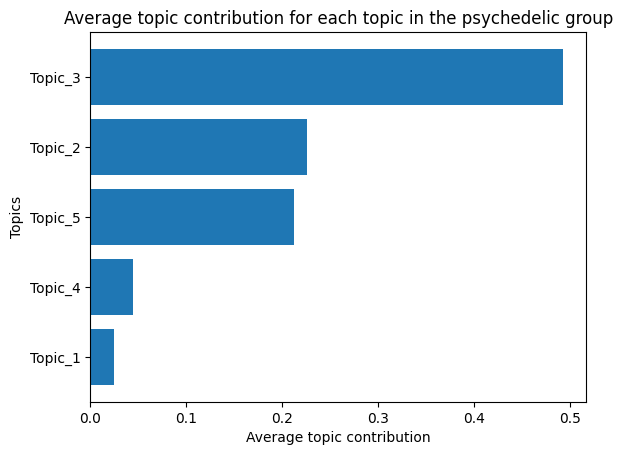

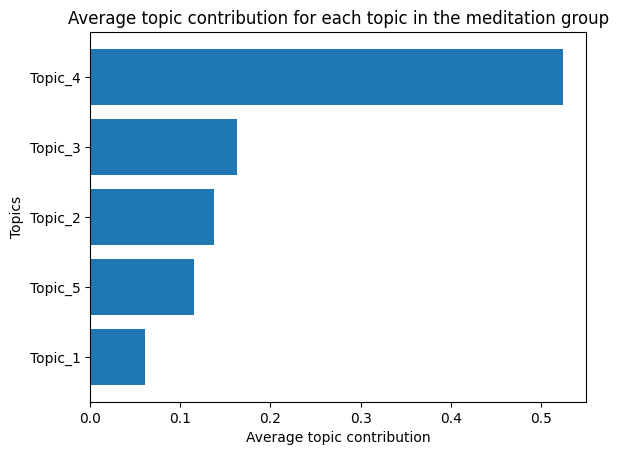

In [73]:
# Visualising the topic contributions for psyke
sorted_topics_psyke = psyke_average_topic_contributions.sort_values()
fig, ax = plt.subplots()
ax.barh(sorted_topics_psyke.index, sorted_topics_psyke.values)
ax.set_xlabel('Average topic contribution')
ax.set_ylabel('Topics')
ax.set_title('Average topic contribution for each topic in the psychedelic group')
plt.show()

# Visualising the topic contributions for medi
sorted_topics_medi = medi_average_topic_contributions.sort_values()
fig, ax = plt.subplots()
ax.barh(sorted_topics_medi.index, sorted_topics_medi.values)
ax.set_xlabel('Average topic contribution')
ax.set_ylabel('Topics')
ax.set_title('Average topic contribution for each topic in the meditation group')
plt.show()


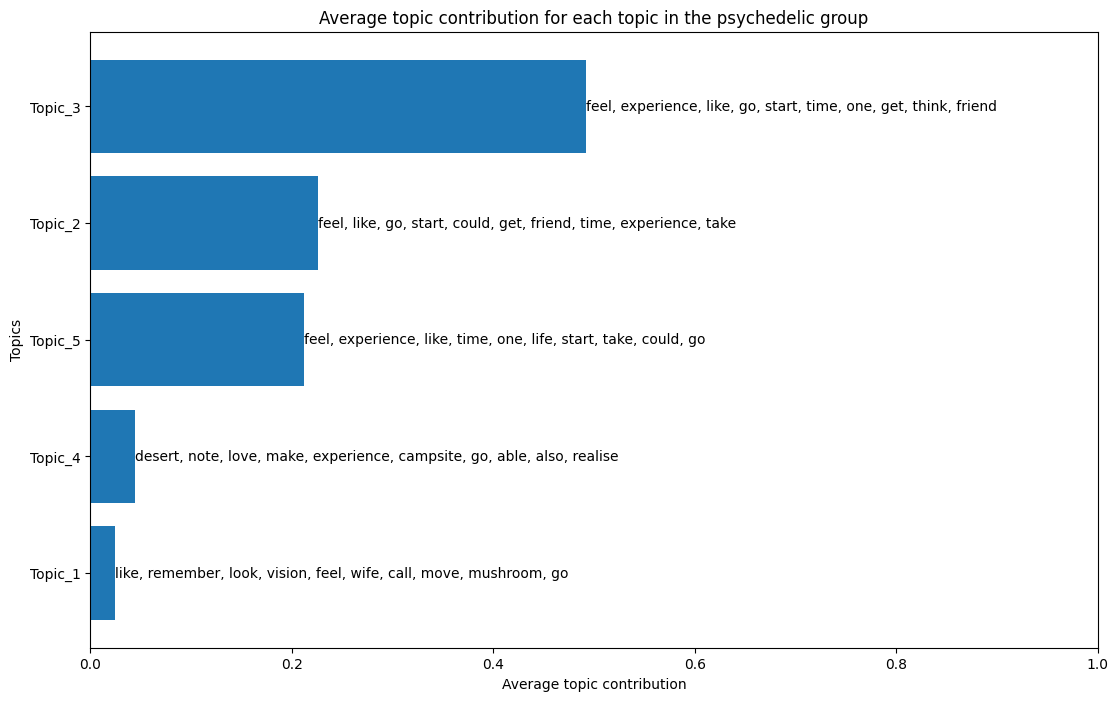

In [74]:
# Visualising the topic contributions with the top words


# Saving the top words into a dict
psyke_top_words_dict = {
    "Topic_1": "like, remember, look, vision, feel, wife, call, move, mushroom, go",
    "Topic_2": "feel, like, go, start, could, get, friend, time, experience, take",
    "Topic_3": "feel, experience, like, go, start, time, one, get, think, friend",
    "Topic_4": "desert, note, love, make, experience, campsite, go, able, also, realise",
    "Topic_5": "feel, experience, like, time, one, life, start, take, could, go"
}


# Creating the visualisation
sorted_topics_psyke = psyke_average_topic_contributions.sort_values()
fig, ax = plt.subplots(figsize=(13, 8))  # Adjust the size as needed
bars = ax.barh(sorted_topics_psyke.index, sorted_topics_psyke.values)

# Add top words next to the bars
for bar, topic in zip(bars, sorted_topics_psyke.index):
    ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, psyke_top_words_dict[topic], 
            va='center')  # Center the text vertically

ax.set_xlabel('Average topic contribution')
ax.set_ylabel('Topics')
ax.set_title('Average topic contribution for each topic in the psychedelic group')

# Set the limits of the x-axis
ax.set_xlim([0, 1])

plt.show()

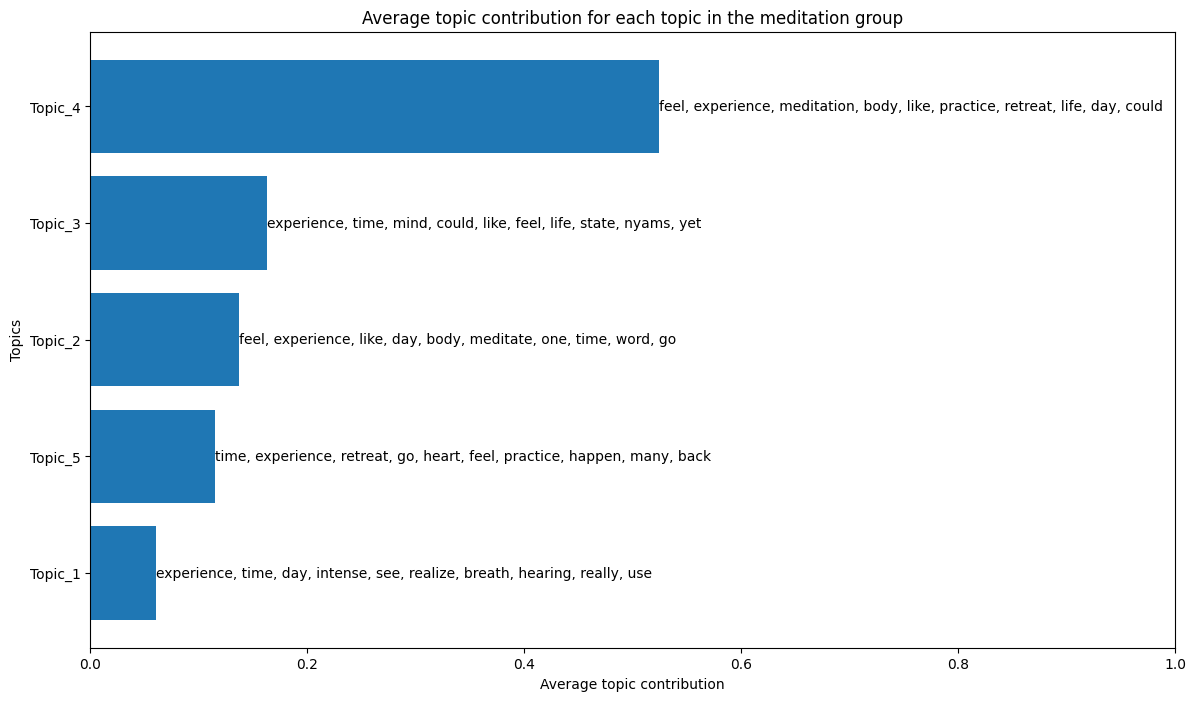

In [75]:
# Doing the same for medi topics
medi_top_words_dict = {
    "Topic_1": "experience, time, day, intense, see, realize, breath, hearing, really, use",
    "Topic_2": "feel, experience, like, day, body, meditate, one, time, word, go",
    "Topic_3": "experience, time, mind, could, like, feel, life, state, nyams, yet",
    "Topic_4": "feel, experience, meditation, body, like, practice, retreat, life, day, could",
    "Topic_5": "time, experience, retreat, go, heart, feel, practice, happen, many, back"
}


# Visualising the topic contributions for medi
sorted_topics_medi = medi_average_topic_contributions.sort_values()
fig, ax = plt.subplots(figsize=(14, 8))  # Adjust the size as needed
bars = ax.barh(sorted_topics_medi.index, sorted_topics_medi.values)

# Add top words next to the bars
for bar, topic in zip(bars, sorted_topics_medi.index):
    ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, medi_top_words_dict[topic], 
            va='center')  # Center the text vertically

ax.set_xlabel('Average topic contribution')
ax.set_ylabel('Topics')
ax.set_title('Average topic contribution for each topic in the meditation group')

# Set the limits of the x-axis
ax.set_xlim([0, 1])

plt.show()

# Sentiment analysis

In [76]:
psyke.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 138 entries, 66 to 212
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   group                       138 non-null    object
 1   age                         138 non-null    int64 
 2   gender_1F_2M_3O             138 non-null    int64 
 3   income_level                138 non-null    int64 
 4   education_level             138 non-null    int64 
 5   Open_report typo-corrected  138 non-null    object
dtypes: int64(4), object(2)
memory usage: 7.5+ KB


In [77]:
medi.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 65 entries, 0 to 65
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   group                       65 non-null     object
 1   age                         65 non-null     int64 
 2   gender_1F_2M_3O             65 non-null     int64 
 3   income_level                65 non-null     int64 
 4   education_level             65 non-null     int64 
 5   Open_report typo-corrected  65 non-null     object
dtypes: int64(4), object(2)
memory usage: 3.6+ KB


In [78]:
from nltk.sentiment import SentimentIntensityAnalyzer




In [79]:
try:
    sia = SentimentIntensityAnalyzer()
except LookupError:
    nltk.download('vader_lexicon')
    sia = SentimentIntensityAnalyzer()


In [84]:
# Adding sentiment scores to both dataframes

psyke.loc[:, 'sentiment_scores'] = psyke['Open_report typo-corrected'].apply(lambda x: sia.polarity_scores(x))

psyke.loc[:, 'compound_sentiment'] = psyke['sentiment_scores'].apply(lambda x: x['compound'])
psyke.loc[:, 'positive_sentiment'] = psyke['sentiment_scores'].apply(lambda x: x['pos'])
psyke.loc[:, 'neutral_sentiment'] = psyke['sentiment_scores'].apply(lambda x: x['neu'])
psyke.loc[:, 'negative_sentiment'] = psyke['sentiment_scores'].apply(lambda x: x['neg'])

medi.loc[:, 'sentiment_scores'] = medi['Open_report typo-corrected'].apply(lambda x: sia.polarity_scores(x))

medi.loc[:, 'compound_sentiment'] = medi['sentiment_scores'].apply(lambda x: x['compound'])
medi.loc[:, 'positive_sentiment'] = medi['sentiment_scores'].apply(lambda x: x['pos'])
medi.loc[:, 'neutral_sentiment'] = medi['sentiment_scores'].apply(lambda x: x['neu'])
medi.loc[:, 'negative_sentiment'] = medi['sentiment_scores'].apply(lambda x: x['neg'])


psyke[['compound_sentiment', 'positive_sentiment', 'neutral_sentiment', 'negative_sentiment']].head(2)

,compound_sentiment,positive_sentiment,neutral_sentiment,negative_sentiment
66,0.9826,0.140,0.841,0.018
67,0.5668,0.098,0.843,0.059


In [85]:
medi[['compound_sentiment', 'positive_sentiment', 'neutral_sentiment', 'negative_sentiment']].head(2)

,compound_sentiment,positive_sentiment,neutral_sentiment,negative_sentiment
0,0.3182,0.035,0.965,0.0
1,0.8689,0.282,0.718,0.0


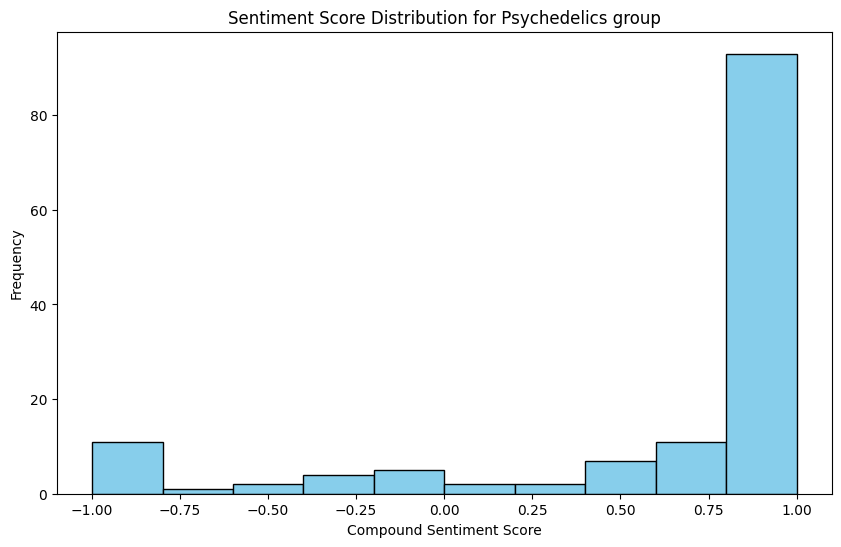

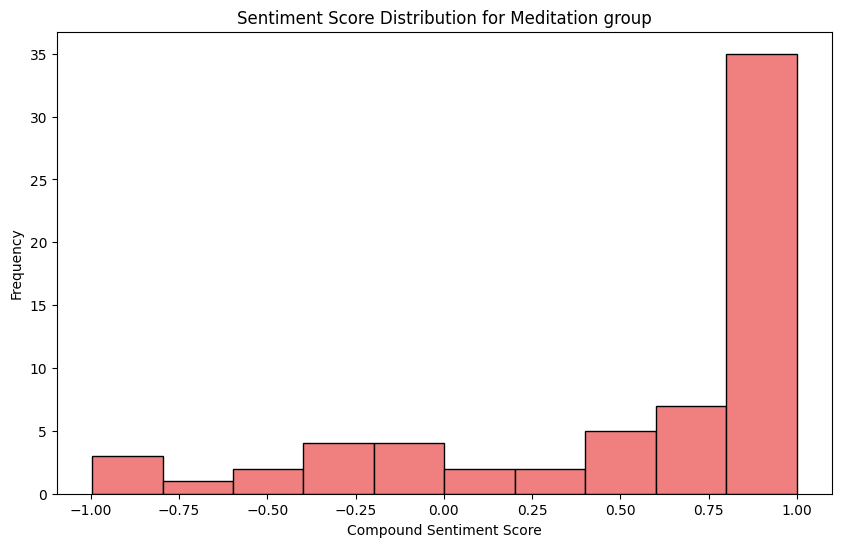

In [86]:
# Creating a sentiment histogram for Psychedelics group
plt.figure(figsize=(10,6))
plt.hist(psyke['compound_sentiment'], bins=10, color='skyblue', edgecolor='black')

# Add labels and a title
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Frequency')
plt.title('Sentiment Score Distribution for Psychedelics group')

# Show the plot
plt.show()

# Creating a sentiment histogram for Meditation group
plt.figure(figsize=(10,6))
plt.hist(medi['compound_sentiment'], bins=10, color='lightcoral', edgecolor='black')

# Add labels and a title
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Frequency')
plt.title('Sentiment Score Distribution for Meditation group')

# Show the plot
plt.show()

### Sentiment scores by the group

In [87]:
# Difference in different sentiments

psyke_avg_comp = round(psyke['compound_sentiment'].mean(), 2)
psyke_std_comp = round(psyke['compound_sentiment'].std(), 2)

psyke_median_comp = round(psyke['compound_sentiment'].median(), 2)


medi_avg_comp = round(medi['compound_sentiment'].mean(), 2)
medi_std_comp = round(medi['compound_sentiment'].std(), 2)

medi_median_comp = round(medi['compound_sentiment'].median(), 2)


print('Psychedelics average compound score: '+str(psyke_avg_comp)+ ' ('+str(psyke_std_comp) +').')
print('Meditation average compound score: '+str(medi_avg_comp)+ ' ('+str(medi_std_comp)+').')
print('Psychedelics compound median: ' +str(psyke_median_comp))
print('Meditation compound median: ' +str(medi_median_comp))


psyke_avg_pos = round(psyke['positive_sentiment'].mean(), 2)
psyke_std_pos = round(psyke['positive_sentiment'].std(), 2)

psyke_median_pos = round(psyke['positive_sentiment'].median(), 2)


medi_avg_pos = round(medi['positive_sentiment'].mean(), 2)
medi_std_pos = round(medi['positive_sentiment'].std(), 2)

medi_median_pos = round(medi['positive_sentiment'].median(), 2)


print('Psychedelics average positive score: '+str(psyke_avg_pos)+ ' ('+str(psyke_std_pos) +').')
print('Meditation average positive score: '+str(medi_avg_pos)+ ' ('+str(medi_std_pos)+').')
print('Psychedelics positive median: ' +str(psyke_median_pos))
print('Meditation positive median: ' +str(medi_median_pos))


psyke_avg_neg = round(psyke['negative_sentiment'].mean(), 2)
psyke_std_neg = round(psyke['negative_sentiment'].std(), 2)

psyke_median_neg = round(psyke['negative_sentiment'].median(), 2)


medi_avg_neg = round(medi['negative_sentiment'].mean(), 2)
medi_std_neg = round(medi['negative_sentiment'].std(), 2)

medi_median_neg = round(medi['negative_sentiment'].median(), 2)


print('Psychedelics average negative score: '+str(psyke_avg_neg)+ ' ('+str(psyke_std_neg) +').')
print('Meditation average negative score: '+str(medi_avg_neg)+ ' ('+str(medi_std_neg)+').')
print('Psychedelics negative median: ' +str(psyke_median_neg))
print('Meditation negative median: ' +str(medi_median_neg))


psyke_avg_neu = round(psyke['neutral_sentiment'].mean(), 2)
psyke_std_neu = round(psyke['neutral_sentiment'].std(), 2)

psyke_median_neu = round(psyke['neutral_sentiment'].median(), 2)


medi_avg_neu = round(medi['neutral_sentiment'].mean(), 2)
medi_std_neu = round(medi['neutral_sentiment'].std(), 2)

medi_median_neu = round(medi['neutral_sentiment'].median(), 2)


print('Psychedelics average neutral score: '+str(psyke_avg_neu)+ ' ('+str(psyke_std_neu) +').')
print('Meditation average neutral score: '+str(medi_avg_neu)+ ' ('+str(medi_std_neu)+').')
print('Psychedelics neutral median: ' +str(psyke_median_neu))
print('Meditation neutral median: ' +str(medi_median_neu))


Psychedelics average compound score: 0.64 (0.6).
Meditation average compound score: 0.55 (0.58).
Psychedelics compound median: 0.95
Meditation compound median: 0.88
Psychedelics average positive score: 0.15 (0.08).
Meditation average positive score: 0.13 (0.08).
Psychedelics positive median: 0.14
Meditation positive median: 0.12
Psychedelics average negative score: 0.07 (0.05).
Meditation average negative score: 0.06 (0.07).
Psychedelics negative median: 0.06
Meditation negative median: 0.04
Psychedelics average neutral score: 0.78 (0.09).
Meditation average neutral score: 0.81 (0.09).
Psychedelics neutral median: 0.79
Meditation neutral median: 0.82


### Mann-Whitney U-tests for pairwise comparisons
The sentiment distributions are heavily skewed, so let's use a non-parametric test for the pairwise comparisons. 

In [88]:
from scipy.stats import mannwhitneyu

# Calculate U-statistics and p-values

u_stat_comp, p_val_comp = mannwhitneyu(psyke['compound_sentiment'], medi['compound_sentiment'])
u_stat_pos, p_val_pos = mannwhitneyu(psyke['positive_sentiment'], medi['positive_sentiment'])
u_stat_neg, p_val_neg = mannwhitneyu(psyke['negative_sentiment'], medi['negative_sentiment'])
u_stat_neu, p_val_neu = mannwhitneyu(psyke['neutral_sentiment'], medi['neutral_sentiment'])

# Print U-statistics and p-values
print("Compound sentiment: U-statistic = ", u_stat_comp, ", p-value = ", p_val_comp)
print("Positive sentiment: U-statistic = ", u_stat_pos, ", p-value = ", p_val_pos)
print("Negative sentiment: U-statistic = ", u_stat_neg, ", p-value = ", p_val_neg)
print("Neutral sentiment: U-statistic = ", u_stat_neu, ", p-value = ", p_val_neu)


Compound sentiment: U-statistic =  5184.0 , p-value =  0.07365448286139599
Positive sentiment: U-statistic =  5371.0 , p-value =  0.023343665752430458
Negative sentiment: U-statistic =  5594.5 , p-value =  0.0044876074339588335
Neutral sentiment: U-statistic =  3528.0 , p-value =  0.014305730553076202


In [89]:
from statsmodels.stats.multitest import multipletests

# Collect all p-values into a list
p_values = [p_val_comp, p_val_pos, p_val_neg, p_val_neu]

# Apply Bonferroni correction
_, p_values_corrected, _, _ = multipletests(p_values, method='bonferroni')

# Print corrected p-values
print('U-test corrected results:')
print("Corrected p-value for Compound sentiment =", p_values_corrected[0])
print("Corrected p-value for Positive sentiment =", p_values_corrected[1])
print("Corrected p-value for Negative sentiment =", p_values_corrected[2])
print("Corrected p-value for Neutral sentiment =", p_values_corrected[3])

U-test corrected results:
Corrected p-value for Compound sentiment = 0.29461793144558396
Corrected p-value for Positive sentiment = 0.09337466300972183
Corrected p-value for Negative sentiment = 0.017950429735835334
Corrected p-value for Neutral sentiment = 0.05722292221230481


In [90]:
# Calculating effect sizes for the differences in sentiments

from scipy.stats import norm

# Calculate the mean and standard deviation of U
n1 = len(psyke['compound_sentiment'])
n2 = len(medi['compound_sentiment'])
mean_U = n1 * n2 / 2
std_dev_U = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)

# Calculate the z-scores
z_comp = (u_stat_comp - mean_U) / std_dev_U
z_pos = (u_stat_pos - mean_U) / std_dev_U
z_neg = (u_stat_neg - mean_U) / std_dev_U
z_neu = (u_stat_neu - mean_U) / std_dev_U

# Calculate the effect sizes
r_comp = round(z_comp / np.sqrt(n1 + n2), 3)
r_pos = round(z_pos / np.sqrt(n1 + n2), 3)
r_neg = round(z_neg / np.sqrt(n1 + n2), 3)
r_neu = round(z_neu / np.sqrt(n1 + n2), 3)

# Print the effect sizes
print("Compound sentiment: r =", r_comp)
print("Positive sentiment: r =", r_pos)
print("Negative sentiment: r =", r_neg)
print("Neutral sentiment: r =", r_neu)

Compound sentiment: r = 0.126
Positive sentiment: r = 0.159
Negative sentiment: r = 0.199
Neutral sentiment: r = -0.172
